In [1]:
%matplotlib inline

# Semantic Segmentation Training
This notebook trains a U-Net model on the SUN RGB-D dataset to segment room layouts and furniture.


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import transforms
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.utils.metrics import IoU, Fscore, Accuracy

from PIL import Image

import os
import glob
import re

from tqdm import tqdm


In [8]:
# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


## Load Data
- Use `SUNRGBDDataset` class to load training/test splits.
- Initialize data loaders.

In [11]:
# Transform for RGB images
transform = transforms.Compose([
    transforms.Resize((256, 256)),   # Resize images to a fixed size
    transforms.ToTensor(),            # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Transform for label images (ensuring integer class indices and resizing)
label_transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=Image.NEAREST),  # Resize with nearest neighbor
    transforms.Lambda(lambda x: torch.from_numpy(np.array(x)).long())  # Convert to tensor with integer values
])

# Apply transformations in the dataset class
class SUNRGBDDataset(Dataset):
    def __init__(self, dataframe, rgb_dir, label_dir, transform=None, label_transform=None):
        self.dataframe = dataframe
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.transform = transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  # RGB image file name
        label_name = self.dataframe.iloc[idx, 1]  # Label image file name
        
        # Construct full paths
        img_path = os.path.join(self.rgb_dir, img_name)
        label_path = os.path.join(self.label_dir, label_name)

        # Load the images
        rgb_image = Image.open(img_path).convert("RGB")
        label_image = Image.open(label_path).convert("L")  # Convert to grayscale if necessary

        label_array = np.array(label_image)

        # Apply transformations to RGB image
        if self.transform:
            rgb_image = self.transform(rgb_image)

        # Apply transformations to label image
        if self.label_transform:
            label_image = self.label_transform(label_image)
        
        return rgb_image, label_image


In [12]:
# Paths to the directories
rgb_dir = "C:/Project Deep Learning/data"
labels_dir = "C:/Project Deep Learning/data/labels_37"

# Define the paths to training and validation splits
train_df = pd.read_csv("C:/Project Deep Learning/data/splits/train_split.csv")
valid_df = pd.read_csv("C:/Project Deep Learning/data/splits/valid_split.csv")
test_df = pd.read_csv("C:/Project Deep Learning/data/splits/test_split.csv")

# Create the datasets for training and validation
train_dataset = SUNRGBDDataset(
    train_df, 
    rgb_dir, 
    labels_dir, 
    transform, 
    label_transform
)
valid_dataset = SUNRGBDDataset(
    valid_df, 
    rgb_dir, 
    labels_dir, 
    transform, 
    label_transform
)
test_dataset = SUNRGBDDataset(
    test_df, 
    rgb_dir, 
    labels_dir, 
    transform, 
    label_transform
)


In [146]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=8, 
    shuffle=True, 
    pin_memory=True
)
valid_loader = DataLoader(
    valid_dataset, 
    batch_size=8, 
    shuffle=False, 
    pin_memory=True
)
test_loader = DataLoader(
    valid_dataset, 
    batch_size=8, 
    shuffle=False, 
    pin_memory=True
)

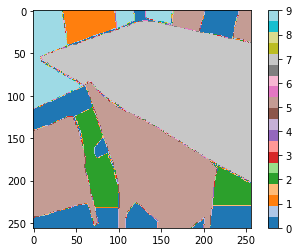

In [7]:
# Get one sample from the dataset
rgb, label = train_dataset[0]  # Load first sample

import matplotlib.pyplot as plt
plt.imshow(label.cpu().numpy(), cmap="tab20")  # Use cmap="gray" for grayscale images
plt.colorbar()
plt.show()


## Define the Model
- Implement U-Net architecture.
- Print model summary.



In [7]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",   # ResNet-34 backbone
    encoder_weights="imagenet", # Use pretrained weights
    classes=38,                 # Number of segmentation classes
    # activation="softmax"        # Use softmax for multi-class segmentation
)


## Training Loop
- Define loss function (`CrossEntropyLoss`).
- Set up optimizer (`Adam`).
- Train the model and log losses.



In [8]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# Find the latest checkpoint file
checkpoint_files = sorted(glob.glob("C:/Project Deep Learning/models/checkpoint_epoch_*.pth"))
if checkpoint_files:
    latest_checkpoint = checkpoint_files[-1]  # Pick the most recent checkpoint
    checkpoint = torch.load(latest_checkpoint, weights_only=True)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"✅ Resuming training from {latest_checkpoint} (Epoch {start_epoch})")
else:
    start_epoch = 0  # Start from scratch if no checkpoint is found

✅ Resuming training from checkpoint_epoch_9.pth (Epoch 9)


In [14]:
num_epochs = 10

# Training loop
for epoch in range(start_epoch, num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (rgb_images, label_images) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")):
        rgb_images = rgb_images.to(device)
        label_images = label_images.to(device)

        optimizer.zero_grad()
        outputs = model(rgb_images)
        loss = criterion(outputs, label_images)
        loss.backward()
        
        # Debug: Check for NaN gradients
        for name, param in model.named_parameters():
            if torch.isnan(param.grad).any():
                print(f"NaN gradient detected in {name}")

        optimizer.step()
        running_loss += loss.item()

        # Debugging loss values
        if batch_idx <= 5:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    # Compute average loss
    epoch_loss = running_loss / len(train_loader)
    print(f"🔹 Epoch {epoch+1}/{num_epochs} - Average Loss: {epoch_loss:.4f}")
    
    # Save checkpoint with epoch number in filename
    checkpoint_path = f"C:/Project Deep Learning/models/checkpoint_epoch_{epoch+1}.pth"
    checkpoint = {
        'epoch': epoch + 1,  # Save the next epoch number
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': epoch_loss
    }
    torch.save(checkpoint, checkpoint_path)
    print(f"✅ Checkpoint saved at '{checkpoint_path}' (Epoch {epoch+1})")

    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for rgb_images, label_images in valid_loader:
            rgb_images = rgb_images.to(device)
            label_images = label_images.to(device)

            if label_images.dim() == 4:
                label_images = label_images.squeeze(1)

            outputs = model(rgb_images)
            loss = criterion(outputs, label_images)
            val_loss += loss.item()

    val_loss /= len(valid_loader)
    print(f"📉 Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}")


Epoch 10/10:   0%|                                                                  | 1/1034 [00:06<1:53:37,  6.60s/it]

Batch 0, Loss: 0.9655020833015442


Epoch 10/10:   0%|▏                                                                 | 2/1034 [00:12<1:46:20,  6.18s/it]

Batch 1, Loss: 1.2008641958236694


Epoch 10/10:   0%|▏                                                                 | 3/1034 [00:18<1:44:20,  6.07s/it]

Batch 2, Loss: 1.4176902770996094


Epoch 10/10:   0%|▎                                                                 | 4/1034 [00:24<1:42:12,  5.95s/it]

Batch 3, Loss: 1.0318571329116821


Epoch 10/10:   0%|▎                                                                 | 5/1034 [00:29<1:39:01,  5.77s/it]

Batch 4, Loss: 1.2902772426605225


Epoch 10/10:   1%|▍                                                                 | 6/1034 [00:35<1:38:34,  5.75s/it]

Batch 5, Loss: 1.145067572593689


Epoch 10/10: 100%|███████████████████████████████████████████████████████████████| 1034/1034 [2:21:17<00:00,  8.20s/it]


🔹 Epoch 10/10 - Average Loss: 1.1246
✅ Checkpoint saved at 'checkpoint_epoch_10.pth' (Epoch 10)
📉 Epoch [10/10], Validation Loss: 1.2331


## Evaluation
- Compute validation metrics (e.g., IoU).
- Visualize predictions vs. ground truth.



In [77]:
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [78]:
print(f"Total test batches: {len(test_loader)}")

Total test batches: 130


In [80]:
# Initialize metrics
iou = IoU(threshold=0.5)  # IoU with a threshold of 0.5
dice = Fscore(threshold=0.5)  # F-score (Dice Score) with a threshold of 0.5
accuracy = Accuracy(threshold=0.5)  # Accuracy with a threshold of 0.5


In [98]:
# Initialize metric accumulators
total_iou = 0.0
total_dice = 0.0
total_accuracy = 0.0
num_batches = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, masks in tqdm(test_loader):  # Replace test_loader with your DataLoader
        # Move data to the correct device (e.g., GPU)
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)

        # Convert logits to predicted class labels (indices)
        outputs = torch.argmax(outputs, dim=1)  # Shape: (batch_size, height, width)

        # Compute metrics
        total_iou += iou(outputs, masks).item()
        total_dice += dice(outputs, masks).item()
        total_accuracy += accuracy(outputs, masks).item()

        num_batches += 1

# Average metrics over all batches
avg_iou = total_iou / num_batches
avg_dice = total_dice / num_batches
avg_accuracy = total_accuracy / num_batches

print(f"IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Accuracy: {avg_accuracy:.4f}")


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [09:51<00:00,  4.55s/it]

IoU: 1.1636, Dice: 1.0522, Accuracy: 0.3354


In [82]:
outputs = model(images)  # Shape will be (batch_size, num_classes, height, width)
outputs = torch.softmax(outputs, dim=1)  # Apply softmax along the class dimension (dim=1)


In [92]:
predictions = torch.argmax(outputs, dim=1)  # Get the predicted class for each pixel
predictions

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [2, 2, 2,  ..., 1, 1, 1],
         [2, 2, 2,  ..., 1, 1, 1],
         [2, 2, 2,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2],
         [2, 2, 2,  ..., 2, 2, 2]],

        ...,

        [[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 5,  ..., 5, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1,

In [100]:
# Initialize metrics
iou_metric = IoU(eps=1e-7, threshold=0.5)
fscore_metric = Fscore(eps=1e-7, threshold=0.5)
accuracy_metric = Accuracy(threshold=0.5)

# Initialize variables to accumulate metrics
iou_total, fscore_total, accuracy_total = 0, 0, 0
num_batches = 0

with torch.no_grad():  # Disable gradient calculation during evaluation
    for batch in test_loader:  # Loop through the test set
        images, targets = batch  # Assuming batch contains (images, targets)
        
        # Move to appropriate device (CPU or GPU)
        images, targets = images.to(device), targets.to(device)

        # Get model predictions
        predictions = model(images)  # Assuming your model returns logits (or probabilities)
        predictions = torch.argmax(predictions, dim=1)  # Shape: (batch_size, height, width)


        # Calculate metrics
        iou_total += iou_metric(predictions, targets)
        fscore_total += fscore_metric(predictions, targets)
        accuracy_total += accuracy_metric(predictions, targets)

        num_batches += 1

# Average metrics across batches
iou_avg = iou_total / num_batches
fscore_avg = fscore_total / num_batches
accuracy_avg = accuracy_total / num_batches

# Print results
print(f"IoU: {iou_avg}")
print(f"F-score: {fscore_avg}")
print(f"Accuracy: {accuracy_avg}")


IoU: 1.1635969877243042
F-score: 1.052172303199768
Accuracy: 0.3354233503341675


In [116]:
iou_metric = IoU(threshold=0.5)
fscore_metric = Fscore(threshold=0.5)
accuracy_metric = Accuracy(threshold=0.5)

iou_total = 0
fscore_total = 0
accuracy_total = 0
num_batches = 0

with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        targets = targets.to(device)

        outputs = model(images)
        predicted_labels = torch.argmax(outputs, dim=1)

        iou = iou_metric(predicted_labels, targets)
        fscore = fscore_metric(predicted_labels, targets)
        accuracy = accuracy_metric(predicted_labels, targets)

        iou_total += iou.item()  # Extract the value from the tensor
        fscore_total += fscore.item()
        accuracy_total += accuracy.item()
        num_batches += 1

iou_avg = iou_total / num_batches
fscore_avg = fscore_total / num_batches
accuracy_avg = accuracy_total / num_batches

print(f"IoU: {iou_avg}")
print(f"F-score: {fscore_avg}")
print(f"Accuracy: {accuracy_avg}")

IoU: 1.1635969808468452
F-score: 1.0521720858720633
Accuracy: 0.33542327880859374


In [117]:
def class_wise_metrics(preds, masks, num_classes):
    class_iou = []
    class_dice = []
    class_accuracy = []

    for class_idx in range(num_classes):
        pred_class = (preds == class_idx).float()
        target_class = (masks == class_idx).float()

        # IoU
        intersection = (pred_class * target_class).sum()
        union = pred_class.sum() + target_class.sum()
        iou = (intersection + 1e-6) / (union - intersection + 1e-6)
        class_iou.append(iou.item())

        # Dice
        dice = (2 * intersection + 1e-6) / (pred_class.sum() + target_class.sum() + 1e-6)
        class_dice.append(dice.item())

        # Accuracy
        correct = (pred_class == target_class).sum()
        total = target_class.numel()
        accuracy = correct / total
        class_accuracy.append(accuracy.item())

    return class_iou, class_dice, class_accuracy

# Compute class-wise metrics
class_iou, class_dice, class_accuracy = class_wise_metrics(preds, masks, num_classes=38)

# Print class-wise metrics
for class_idx in range(38):
    print(f"Class {class_idx}: IoU = {class_iou[class_idx]:.4f}, Dice = {class_dice[class_idx]:.4f}, Accuracy = {class_accuracy[class_idx]:.4f}")

Class 0: IoU = 0.3901, Dice = 0.5613, Accuracy = 4.1648
Class 1: IoU = 1.1600, Dice = 1.0741, Accuracy = 5.6073
Class 2: IoU = 0.1897, Dice = 0.3190, Accuracy = 5.9939
Class 3: IoU = 0.0000, Dice = 0.0000, Accuracy = 7.9996
Class 4: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 5: IoU = 0.0000, Dice = 0.0000, Accuracy = 6.5587
Class 6: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 7: IoU = 0.1082, Dice = 0.1953, Accuracy = 6.3273
Class 8: IoU = 0.0000, Dice = 0.0000, Accuracy = 7.8569
Class 9: IoU = 0.0000, Dice = 0.0000, Accuracy = 7.6752
Class 10: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 11: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 12: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 13: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 14: IoU = 0.0000, Dice = 0.0000, Accuracy = 7.9955
Class 15: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 16: IoU = 1.0000, Dice = 1.0000, Accuracy = 8.0000
Class 17: IoU = 1.0000, Dice = 1.0000, Ac

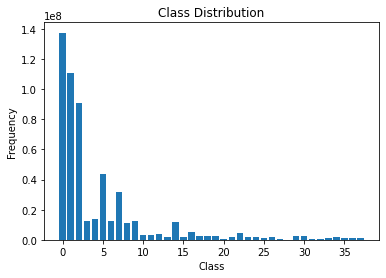

In [118]:
import matplotlib.pyplot as plt

# Get the class distribution in the dataset
class_counts = torch.zeros(38)  

for batch_idx, (images, targets) in enumerate(train_loader):
    for c in range(38):  # 38 is the number of classes
        class_counts[c] += (targets == c).sum()

plt.bar(range(38), class_counts.numpy())
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()


Уникални стойности в targets: tensor([ 0,  1,  2,  3,  5,  7,  8,  9, 14, 22, 23, 26, 29])
Уникални стойности в preds: tensor([ 0,  1,  2,  3,  5,  7,  8,  9, 14, 22, 30])


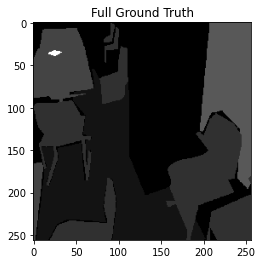

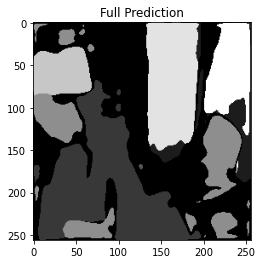

In [125]:
print("Уникални стойности в targets:", torch.unique(targets))
print("Уникални стойности в preds:", torch.unique(preds))
plt.imshow(targets[i].cpu().numpy(), cmap='gray')
plt.title("Full Ground Truth")
plt.show()

plt.imshow(preds[i].cpu().numpy(), cmap='gray')
plt.title("Full Prediction")
plt.show()


In [129]:
for i in range(min(5, len(images))):
    gt_mask = (targets[i].cpu().numpy() == class_idx)
    pred_mask = (preds[i].cpu().numpy() == class_idx)

    print(f"Image {i}: Pixels for class {class_idx} in GT: {np.sum(gt_mask)}")
    print(f"Image {i}: Pixels for class {class_idx} in Prediction: {np.sum(pred_mask)}")



Image 0: Pixels for class 3 in GT: 0
Image 0: Pixels for class 3 in Prediction: 0
Image 1: Pixels for class 3 in GT: 0
Image 1: Pixels for class 3 in Prediction: 0
Image 2: Pixels for class 3 in GT: 0
Image 2: Pixels for class 3 in Prediction: 0
Image 3: Pixels for class 3 in GT: 0
Image 3: Pixels for class 3 in Prediction: 0
Image 4: Pixels for class 3 in GT: 0
Image 4: Pixels for class 3 in Prediction: 23


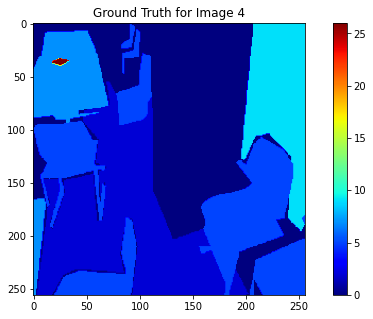

In [130]:
plt.figure(figsize=(10, 5))
plt.imshow(targets[i].cpu().numpy(), cmap="jet")  # jet дава различни цветове за различни класове
plt.colorbar()
plt.title(f"Ground Truth for Image {i}")
plt.show()


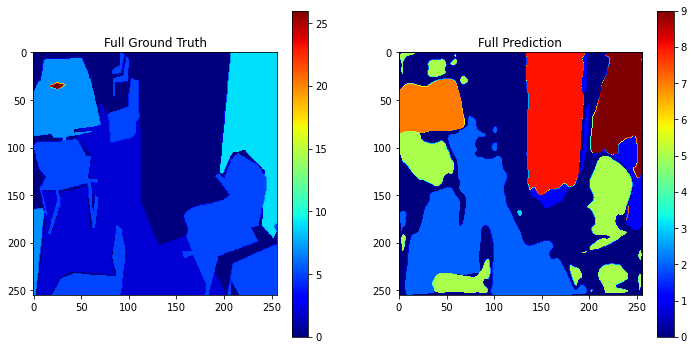

In [132]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(targets[4].cpu().numpy(), cmap="jet")  # jet дава различни цветове за класовете
plt.colorbar()
plt.title("Full Ground Truth")

plt.subplot(1, 2, 2)
plt.imshow(preds[4].cpu().numpy(), cmap="jet")
plt.colorbar()
plt.title("Full Prediction")

plt.show()


In [134]:
class_counts = torch.bincount(targets.flatten())
print("Class frequencies:", class_counts)


Class frequencies: tensor([115382,  85999, 128203,   8319,      0,  88903,      0,  36998,   8991,
         37446,      0,      0,      0,      0,  13352,      0,      0,      0,
             0,      0,      0,      0,    525,     86,      0,      0,     66,
             0,      0,     18])


In [122]:
print(f"Predictions shape: {predictions.shape}")
print(f"Targets shape: {targets.shape}")


Predictions shape: torch.Size([1, 256, 256])
Targets shape: torch.Size([8, 256, 256])


In [104]:
print("Predictions sample:", predictions[0, :10])  # Sample from the first batch (first 10 values)
print("Targets sample:", targets[0, :10])  # Same for targets


Predictions sample: tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])
Targets sample: tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


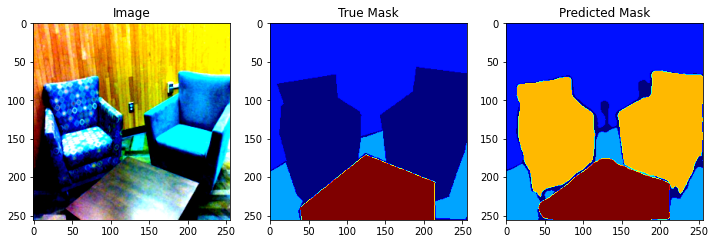

In [145]:
def visualize_predictions(images, masks, preds, num_samples=3):
    batch_size = images.shape[0]  # Get the actual batch size
    num_samples = min(num_samples, batch_size)  # Ensure we don't exceed the batch size

    for i in range(num_samples):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        true_mask = masks[i].cpu().numpy()
        pred_mask = preds[i].cpu().numpy()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap="jet")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap="jet")

        plt.show()

# Visualize predictions
visualize_predictions(images, masks, preds, num_samples=3)

Visualizing batch 1...


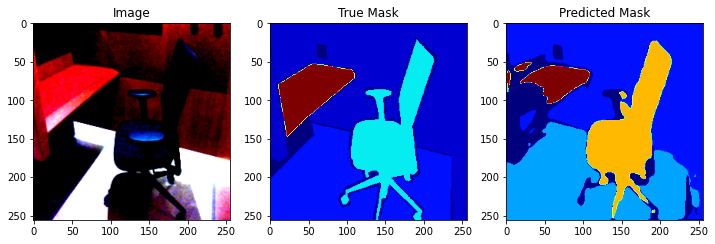

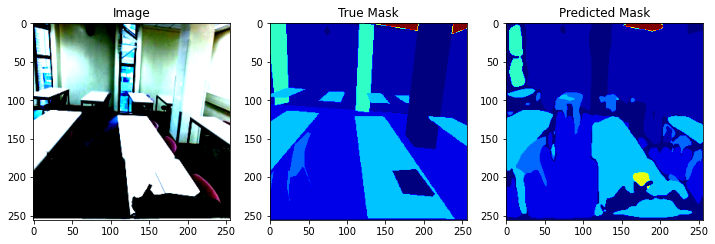

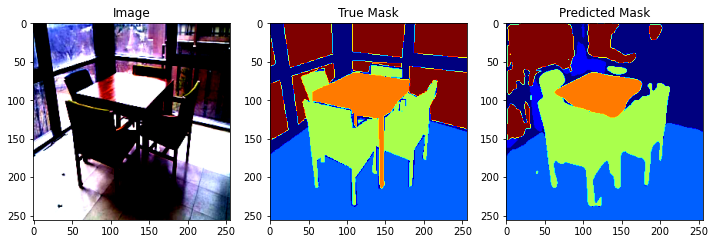

Visualizing batch 2...


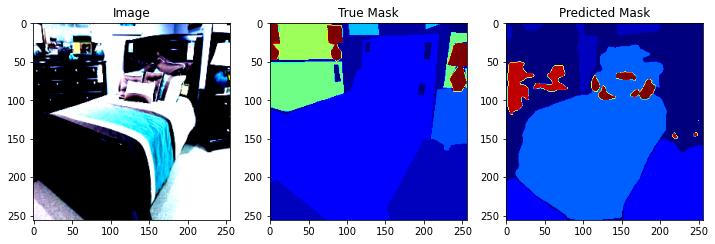

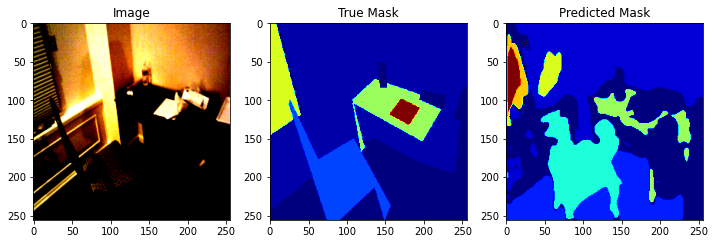

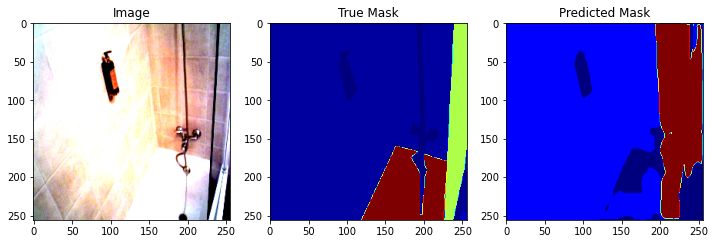

Visualizing batch 3...


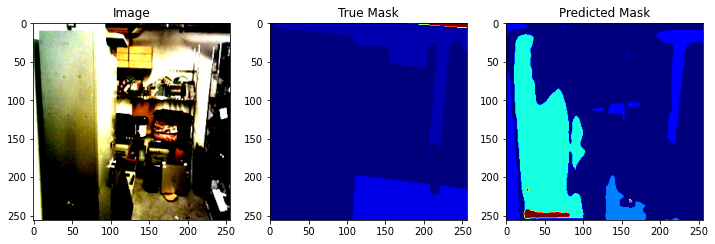

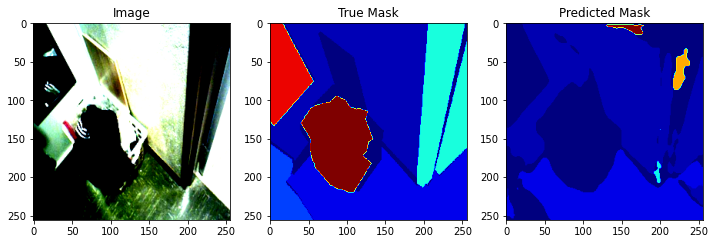

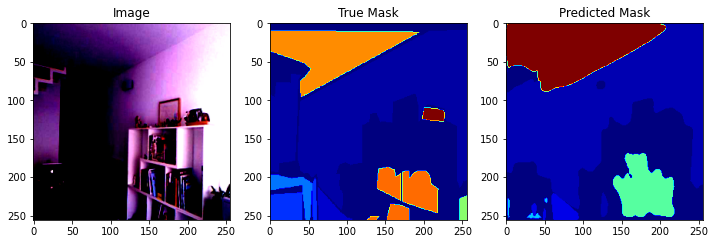

In [150]:
def visualize_predictions(images, masks, preds, num_samples=3):
    batch_size = images.shape[0]  # Get the actual batch size
    num_samples = min(num_samples, batch_size)  # Ensure we don't exceed the batch size

    for i in range(num_samples):
        # Normalize image to [0, 1] for visualization
        image = images[i].cpu().permute(1, 2, 0).numpy()
        image = np.clip(image, 0, 1)  # Clip values to [0, 1]

        # Convert masks to 2D if they are one-hot encoded
        true_mask = masks[i].cpu().numpy()
        pred_mask = preds[i].cpu().numpy()

        if true_mask.ndim == 3:  # If one-hot encoded, convert to 2D
            true_mask = np.argmax(true_mask, axis=0)
        if pred_mask.ndim == 3:  # If one-hot encoded, convert to 2D
            pred_mask = np.argmax(pred_mask, axis=0)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.title("Image")
        plt.imshow(image)

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(true_mask, cmap="jet")

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap="jet")

        plt.show()

# Visualize predictions from multiple batches
num_batches_to_visualize = 3  # Number of batches to visualize
samples_per_batch = 3  # Number of samples to visualize per batch

for batch_idx, (images, masks) in enumerate(test_loader):
    if batch_idx >= num_batches_to_visualize:
        break  # Stop after visualizing the desired number of batches

    images, masks = images.to(device), masks.to(device)

    # Forward pass
    outputs = model(images)
    preds = torch.argmax(outputs, dim=1)

    # Visualize predictions for this batch
    print(f"Visualizing batch {batch_idx + 1}...")
    visualize_predictions(images, masks, preds, num_samples=samples_per_batch)

## Save the Model

In [15]:
torch.save(model.state_dict(), 'C:/Project Deep Learning/models/segmentation_model.pth')

## Load the model

In [10]:
# Define the device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the same model architecture
model = smp.Unet(
    encoder_name="resnet34",   # ResNet-34 backbone
    encoder_weights="imagenet", # Use pretrained weights
    classes=38,                 # Number of segmentation classes
    # activation="softmax"        # Use softmax for multi-class segmentation
)

# Load the trained weights
model.load_state_dict(torch.load('C:/Project Deep Learning/models/segmentation_model.pth', map_location=device))

# Move model to device
model.to(device)

# Set model to evaluation mode
model.eval()
print("✅ Model loaded!")


C:\Users\galin\AppData\Local\Temp\ipykernel_2260\3167933413.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('C:/Project Deep Learning/m

✅ Model loaded!


## Make predictions on unseen data

In [ ]:
class SegmentationPredictor:
    def __init__(self, model, device="cpu", image_size=(256, 256)):
        """Initialize the predictor with a trained model."""
        self.model = model.to(device)
        self.device = device
        self.image_size = image_size
        self.transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])
        self.model.eval()

    def predict(self, image_path):
        """Perform segmentation on a single image."""
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image).unsqueeze(0).to(self.device)
        
        with torch.no_grad():
            output = self.model(image)
        
        output = output.squeeze(0).cpu().numpy()
        segmentation_mask = np.argmax(output, axis=0)
        
        return image_path, segmentation_mask
    
    def visualize(self, image_path, segmentation_mask):
        """Display the original image and segmentation mask."""
        image = Image.open(image_path)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[0].set_title("Original Image")
        ax[0].axis("off")
        
        ax[1].imshow(segmentation_mask, cmap="jet")
        ax[1].set_title("Segmentation Mask")
        ax[1].axis("off")
        
        plt.show()


We can reuse this SegmentationPredictor class for any image path by calling ```predictor.predict(image_path)``` and ```predictor.visualize(image_path, segmentation_mask)```

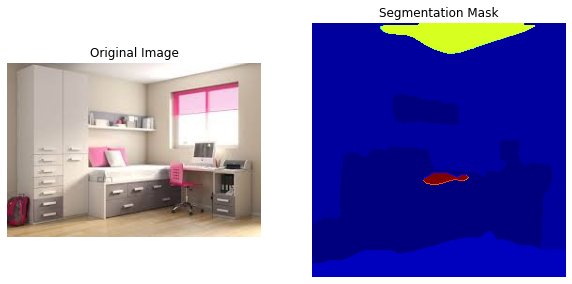

In [29]:
image_path = "C:/Project Deep Learning/outputs/test/test_image.jpg"
predictor = SegmentationPredictor(model, device="cuda" if torch.cuda.is_available() else "cpu")
img_path, seg_mask = predictor.predict(image_path)
predictor.visualize(img_path, seg_mask)

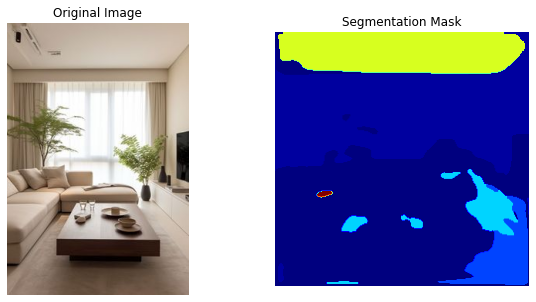

In [25]:
image_path = "C:/Project Deep Learning/data/pinterest/living_room/minimalist/living_room_minimalist_1.jpg"
predictor = SegmentationPredictor(model, device="cuda" if torch.cuda.is_available() else "cpu")
img_path, seg_mask = predictor.predict(image_path)
predictor.visualize(img_path, seg_mask)

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from torch.utils.tensorboard import SummaryWriter

# # 1. Създай модел (както преди)
# model = smp.Unet(
#     encoder_name="resnet34",
#     encoder_weights="imagenet",
#     classes=38,
# )

# 2. Създай SummaryWriter
writer = SummaryWriter("runs/my_segmentation_model")  # Папка, където ще се запишат логовете

# 3. Създай dummy input tensor (примерни входни данни)
dummy_input = torch.randn(1, 3, 256, 256)  # Batch size 1, 3 канала (RGB), размер на изображението 256x256.  Приспособи тези размери към твоите.

# 4. Запиши графа на модела в TensorBoard
writer.add_graph(model, dummy_input)

# 5. Затвори writer-а (добре е да се прави винаги)
writer.close()

# 6. Стартирай TensorBoard
# Отвори терминал и изпълни тази команда в папката, където е скриптът ти:
# tensorboard --logdir runs/my_segmentation_model

# 7. Отвори TensorBoard в браузър
# След изпълнение на горната команда, TensorBoard ще ти даде URL, обикновено нещо като http://localhost:6006/
# Отвори този URL в браузъра си.

# Сега трябва да видиш графата на модела си в TensorBoard.

C:\Users\galin\anaconda3\lib\site-packages\segmentation_models_pytorch\base\model.py:26: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if h % output_stride != 0 or w % output_stride != 0:
